# **KAGGLE di ALESSANDRO DELL'ORTO (num matricola 876909)**

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import IFrame

IFrame(src='https://en.wikipedia.org/wiki/Titanic', width=700, height=500)

# Load the train data

Firstly, we must load the dataset. We use [Panda](https://pandas.pydata.org/) .

In [3]:
train_data = pd.read_csv("train.csv", encoding="utf8", converters={'Sex': lambda x: int(x == 'male')})

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.PassengerId.unique().shape

(891,)

## Extract the target

In [6]:
X = train_data.drop(columns=['Survived','Name','PassengerId','Ticket','Embarked','Cabin'])
y = train_data['Survived']

In [7]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000
887,1,0,19.0,0,0,30.0000
888,3,0,NaN,1,2,23.4500
889,1,1,26.0,0,0,30.0000


In [8]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

# Data imputation

Delete NaN value from Age.
https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [9]:
from sklearn.impute import KNNImputer

In [10]:
imputer = KNNImputer(n_neighbors=4,missing_values=np.nan, add_indicator=True)

In [11]:
X_i=imputer.fit_transform(X)

# Model Selection

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_i, y,random_state=42)

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics

"""
We are going to try different model and choose the one with best score
"""
models = OrderedDict([
          ('Knn', KNeighborsClassifier()),
          ('Logistic Regression', LogisticRegression()),
          ('Linear SVM', SVC(kernel='linear', probability=True)),
          ('Poly SVM', SVC(kernel='poly',  probability=True)),
          ('RBF SVM', SVC(kernel='rbf',  probability=True)),
          ('Classification Tree', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          ('Multilayer Perceptron', MLPClassifier(activation='tanh',solver='adam', max_iter=10000,
                                                  learning_rate_init=0.001, random_state=0))
          ])


def training(X,y,model='Logistic Regression'):
    scorers    = {'f1_score': make_scorer(f1_score),
              'accuracy_score': make_scorer(accuracy_score),
              'precision_score': make_scorer(precision_score)
             }
    if model=='Knn':
        n_neighbors=[1,2,3,4,5,10,20,30]
        knn=models[model]
        gs = GridSearchCV(knn,param_grid={"n_neighbors": n_neighbors},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Gauss Naive Bayes':
        var_smoothing=np.logspace(-10,-6,20)
        gnb=models[model]
        gs = GridSearchCV(gnb,param_grid={"var_smoothing": var_smoothing},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        if sparse.issparse(X):
            Z=X.toarray()
            gs.fit(Z, y)
        else:
            gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Multi Naive Bayes':
        alpha=np.logspace(-3,0,20)
        mnb=models[model]
        gs = GridSearchCV(mnb,param_grid={"alpha": alpha},scoring=scorers,refit='f1_score',cv=10,n_jobs=-1,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='‘Logistic Regression':
        C  = np.logspace(-3,2,5)
        lr = models[model]
        gs = GridSearchCV(lr,param_grid={"C": C},scoring=scorers,refit='f1_score',cv=10,n_jobs=-1,verbose=2)
        gs.fit(X, y)
    
    if model=='Linear SVM':
        C=np.logspace(-3,2,5)
        lsvm=models[model]
        gs = GridSearchCV(lsvm,param_grid={"C": C},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='RBF SVM':
        gamma=np.logspace(-4,1,10)
        C=np.logspace(-3,3,10)
        rsvm=models[model]
        gs = GridSearchCV(rsvm,param_grid={"C": C,"gamma":gamma},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Classification Tree':
        max_depth=[30,40,50,100]
        ct=models[model]
        gs = GridSearchCV(ct,param_grid={"max_depth": max_depth},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Random Forest':
        max_depth=[3,4,5,10,20,30]
        n_estimators=[20,30,50,100,200,300]
        rf=models[model]
        gs = GridSearchCV(rf,param_grid={"max_depth": max_depth,"n_estimators": n_estimators},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=1)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Multilayer Perceptron':
        hidden_layer_sizes=[(2),(3,2),(4,3,2),(5,4,3,2),(6,5,4,3,2),(7,6,5,4,3,2)]
        mlp=models[model]
        gs = GridSearchCV(mlp,param_grid={"hidden_layer_sizes": hidden_layer_sizes},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=5)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,target_names,title='Confusion matrix', cmap=None,normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

In [43]:
target_names = ['Survived','Not Survived']

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-3)]: Done  80 out of  80 | elapsed:    0.2s finished


Best parameter: {'n_neighbors': 3}


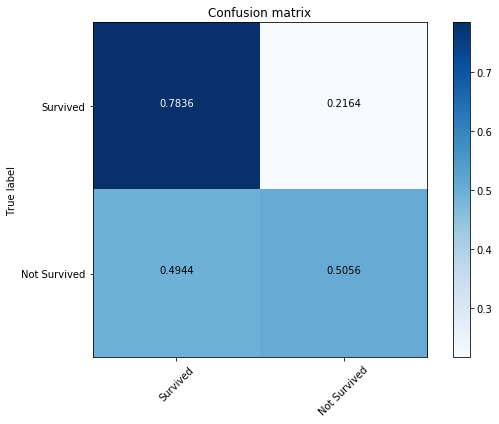

In [70]:
mm,bp,bs=training(X_train,y_train,'Knn')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

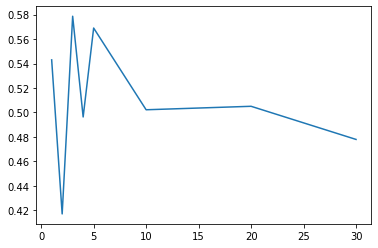

In [76]:
plt.plot([1,2,3,4,5,10,20,30],mm.cv_results_['mean_test_f1_score'])

In [55]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       134
           1       0.61      0.51      0.55        89

    accuracy                           0.67       223
   macro avg       0.66      0.64      0.65       223
weighted avg       0.67      0.67      0.67       223



Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-3)]: Done 360 out of 360 | elapsed:   13.5s finished


Best parameter: {'max_depth': 10, 'n_estimators': 50}


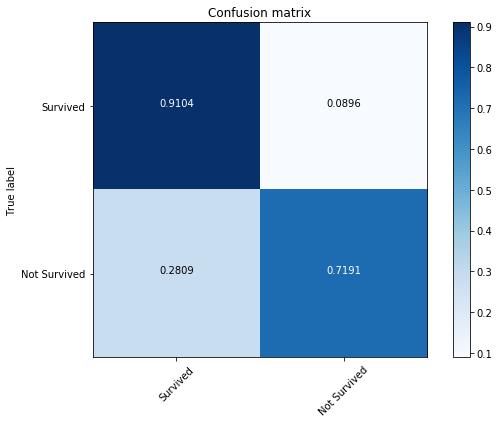

In [56]:
mm,bp,bs=training(X_train,y_train,'Random Forest')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

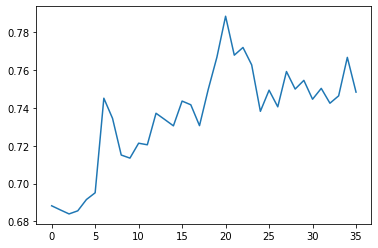

In [58]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

In [59]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       134
           1       0.84      0.72      0.78        89

    accuracy                           0.83       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  54 out of  60 | elapsed:    7.6s remaining:    0.8s
[Parallel(n_jobs=-3)]: Done  60 out of  60 | elapsed:    8.3s finished


Best parameter: {'hidden_layer_sizes': (5, 4, 3, 2)}


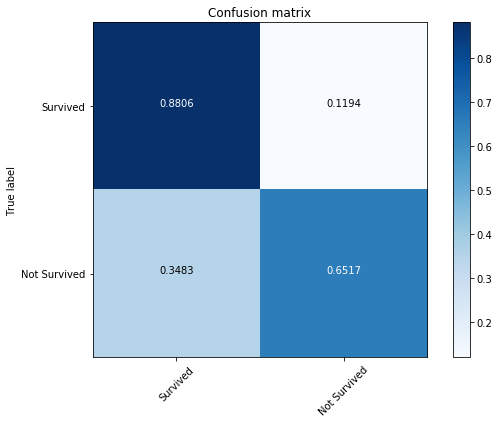

In [62]:
mm,bp,bs=training(X_train,y_train,'Multilayer Perceptron')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

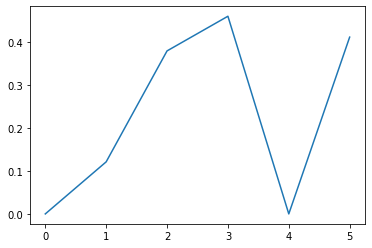

In [69]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameter: {'max_depth': 100}


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 out of  40 | elapsed:    0.1s finished


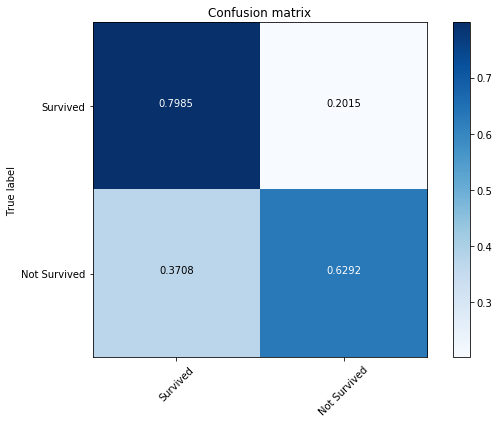

In [81]:
mm,bp,bs=training(X_train,y_train,'Classification Tree')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-3)]: Done 142 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 345 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done 628 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed:   27.4s finished


Best parameter: {'C': 1000.0, 'gamma': 0.0001}


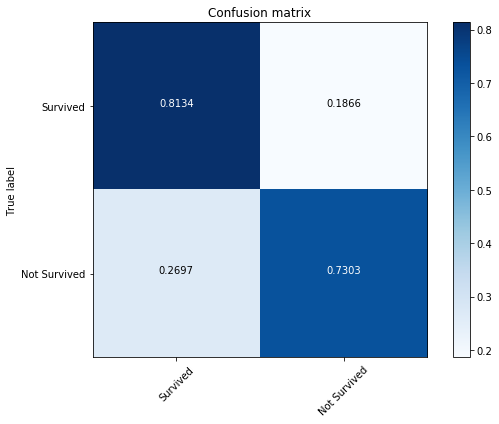

In [77]:
mm,bp,bs=training(X_train,y_train,'RBF SVM')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

In [513]:
clf = MultinomialNB()
sel = SelectKBest()

pipeline   = Pipeline([('sel', sel), ('clf', clf)])

parameters = {'sel__k':np.arange(9000,13000,1000),
              'sel__score_func':[chi2,f_classif],
              'clf__alpha':np.logspace(-3,1,10)
             }

scorers    = {'f1_score': make_scorer(f1_score),
              'recall_score': make_scorer(recall_score),
              'precision_score': make_scorer(precision_score)
             }

gsm = GridSearchCV(pipeline,param_grid=parameters
        ,scoring=scorers,refit='f1_score',cv=10,n_jobs=10,verbose=2)
gsm.fit(X_train, y_train)
print (gsm.best_params_, gsm.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   17.9s


{'clf__alpha': 0.1668100537200059, 'sel__k': 11000, 'sel__score_func': <function chi2 at 0x7f33e31c18c0>} 0.7535767658707774


[Parallel(n_jobs=10)]: Done 800 out of 800 | elapsed:   22.3s finished


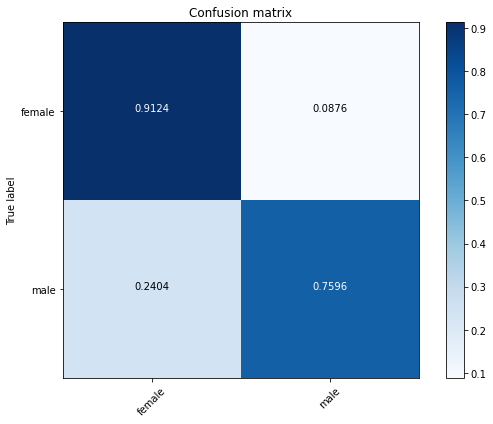

In [514]:
predic = gsm.predict(X_test)

target_names = ['female','male']

confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

In [515]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       913
           1       0.76      0.76      0.76       337

    accuracy                           0.87      1250
   macro avg       0.84      0.84      0.84      1250
weighted avg       0.87      0.87      0.87      1250



In [476]:
clf = ComplementNB()
sel = SelectKBest()

pipeline   = Pipeline([('sel', sel), ('clf', clf)])

parameters = {'sel__k':np.arange(9000,13000,1000),
              'sel__score_func':[chi2,f_classif],
              'clf__alpha':np.logspace(-3,1,10)
             }

scorers    = {'f1_score': make_scorer(f1_score),
              'recall_score': make_scorer(recall_score),
              'precision_score': make_scorer(precision_score)
             }

gsc = GridSearchCV(pipeline,param_grid=parameters
        ,scoring=scorers,refit='f1_score',cv=10,n_jobs=10,verbose=2)
gsc.fit(X_train, y_train)
print (gsc.best_params_, gsc.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 670 tasks      | elapsed:   14.9s


{'clf__alpha': 0.46415888336127775, 'sel__k': 11000, 'sel__score_func': <function chi2 at 0x7f33e31c18c0>} 0.7470224460031624


[Parallel(n_jobs=10)]: Done 800 out of 800 | elapsed:   17.7s finished


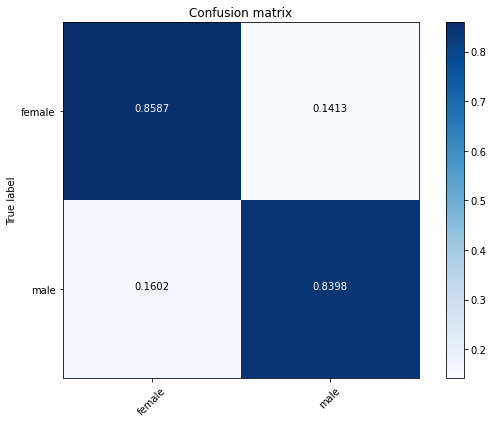

In [477]:
predic = gsc.predict(X_test)

target_names = ['female','male']

confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

In [478]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       913
           1       0.69      0.84      0.76       337

    accuracy                           0.85      1250
   macro avg       0.81      0.85      0.83      1250
weighted avg       0.87      0.85      0.86      1250



Now, we fit the best MNB and CNB models on the full dataset and finally, we determine the *stability* of our models using the cross validation on the full dataset.

In [508]:
best_mnb=gsm.best_estimator_
best_mnb.fit(X,y)
scores=cross_val_score(best_mnb, X, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.03)


In [509]:
best_cnb=gsc.best_estimator_
best_cnb.fit(X,y)
scoresc=cross_val_score(best_cnb, X, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresc.mean(), scoresc.std() * 2))

Accuracy: 0.75 (+/- 0.05)


So the Multinomia Naive Bayes gives the best scores. 

# Prepare the solution

In [486]:
test_data = pd.read_csv("test_data.csv", encoding="utf-8")

In [487]:
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


In [488]:
test_data.author.unique().shape

(15000,)

In [489]:
S_test=subreddit_features(test_data,train=False)


In [490]:
author_text_test = text_features(test_data,train=False)

In [491]:
C = cntvec.transform(author_text_test)
                    
M_test = tfidf.transform(C)

In [492]:
X_test= sparse.hstack([S_test,M_test])

In [493]:
X_test.shape

(15000, 18468)

In [494]:
y_pred = best_mnb.predict_proba(X_test)[:,1]

In [495]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head(80)

,author,gender
0,ejchristian86,1.000000e+00
1,ZenDragon,2.953627e-13
2,savoytruffle,1.817065e-05
3,hentercenter,2.924392e-06
4,rick-o-suave,1.302858e-02
...,...,...
75,IchBinEinHamburger,3.200843e-09
76,wufoo2,9.855281e-01
77,Tall_LA_Bull,9.965454e-01
78,Junoh315,1.046879e-11


In [496]:
solution.to_csv("solutio_best.csv", index=False)